In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('data/tx_hospital_discharges.csv', index_col='Date', parse_dates=True)

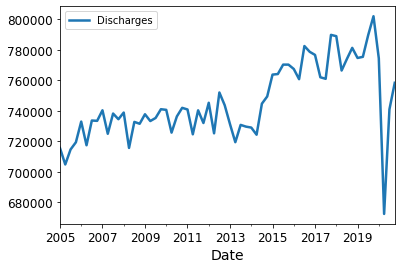

In [32]:
df.plot(linewidth=2.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Date',size=14);

In [41]:
df_1yr = df.rolling(window=4).mean()
df_2yr = df.rolling(window=8).mean()

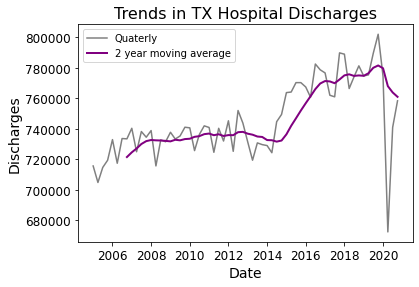

In [68]:
fig, ax = plt.subplots()
ax.plot(df, color='grey', label='Quaterly')
# ax.plot(df_1yr, linewidth=2.0, label='1 yr MA')
ax.plot(df_2yr, color='Purple', linewidth=2.0, label='2 year moving average')
ax.legend()
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Discharges', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Trends in TX Hospital Discharges', fontsize=16);